In [59]:
import json
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS 
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
%matplotlib inline
from collections import Counter
from PIL import Image
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import re
# https://www.kaggle.com/alonalevy/cultural-diffusion-by-recipes
# https://www.kaggle.com/dipayan/whatscooking-python

In [14]:
traindf = pd.read_json("train.json")
testdf = pd.read_json("test.json")
with open('train.json') as data_file:    
    data = json.load(data_file)

In [15]:
ingredients = []
for recipe in traindf['ingredients']:
    ingredients.extend(recipe)    

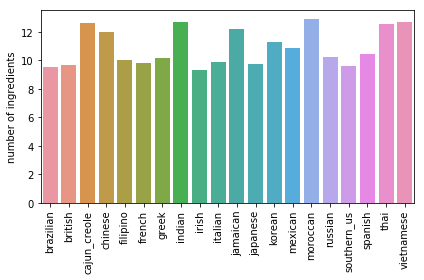

In [24]:
traindf['ingredients_number'] = [len(x) for x in traindf['ingredients']]
avg_number_of_ingredients=traindf[['cuisine', 'ingredients_number']].groupby('cuisine').mean()
x_cu = list(Counter(traindf['cuisine']).keys())
x_cu.sort()
y = pd.Series(avg_number_of_ingredients['ingredients_number'], name='number of ingredients')
fbar = sns.barplot(x = x_cu, y = y)
for item in fbar.get_xticklabels():
    item.set_rotation(90)
plt.tight_layout()
plt.savefig('number_of_ingredients.png')

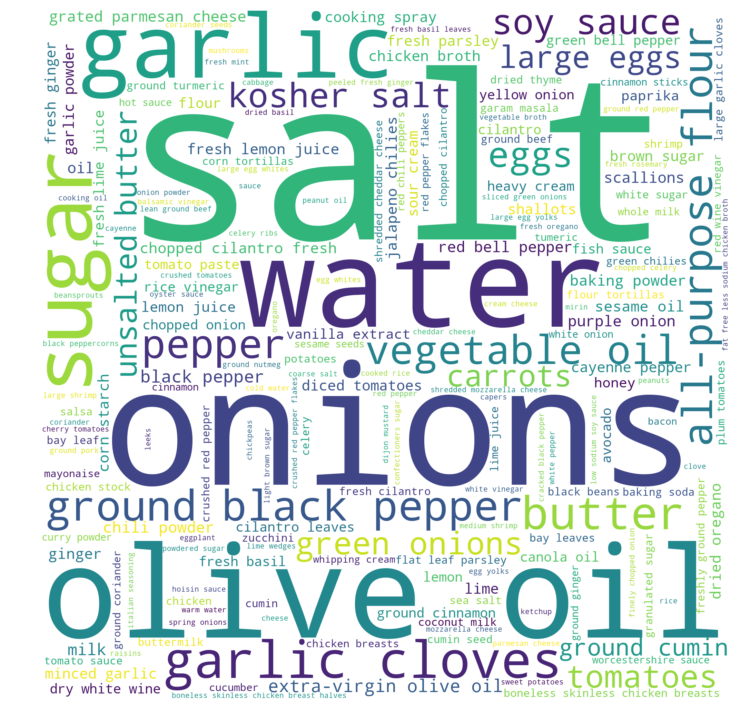

In [23]:
# mask = np.array(Image.open("cloud.png"))  

wordcloud = WordCloud(width=2000, height=2000,
                    background_color ='white',
#                     mask=mask,
                    min_font_size = 20,
                    max_words = 200)
wordcloud.generate_from_frequencies(Counter(ingredients))

plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.savefig('wordcloud.png')  
plt.show() 

c:\users\marcin\appdata\local\programs\python\python37\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


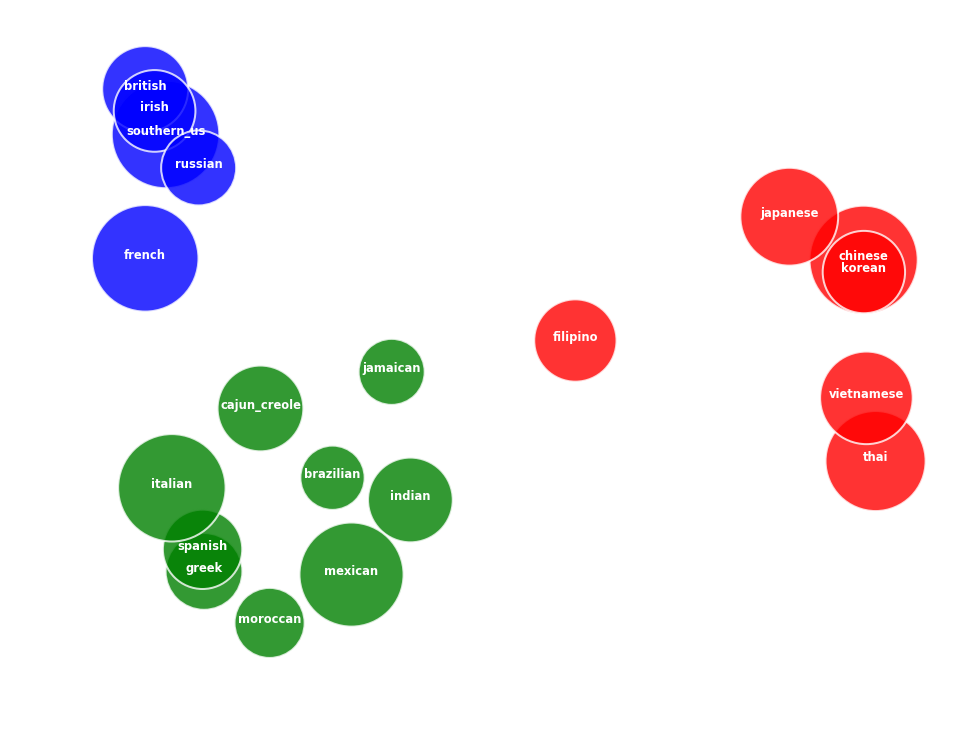

In [55]:
# loading the data
##################
import numpy as np
import json
from sklearn.feature_extraction.text import TfidfTransformer

with open('train.json') as data_file:    
    data = json.load(data_file)

##################################################################
# SECTION 1: From JSON to a countsMatrix 
# countsMatrix is a matrix where the [i,j] cell is the number of 
# times ingredient j appears in cuisine i (total number of appearances
# over all recipes for that cuisine). This is a preliminary 
# step required for running tf-idf. 
##################################################################


# This function creates a dictionary of ingredients per
# cuisine (takes all ingredients from all recipes for that
# cuisine to create one large vector. At this stage ingredients 
# can appear more than once per cuisine as this will be used
# to create the tf-idf matrix later on).
##################################################################
def create_dict_cuisine_ingred(json):
    dictCuisineIngred = {}
    cuisines = []
    ingredients = []
    
    for i in range(len(json)):
        
        # just changing the name of one of the cuisines so
        # it is more readable in the final visualization
        cuisine = json[i]['cuisine']
#         if cuisine == 'southern_us':
#             cuisine = 'southUS'

        ingredientsPerCuisine = json[i]['ingredients']
        
        if cuisine not in dictCuisineIngred.keys():
            cuisines.append(cuisine)
            dictCuisineIngred[cuisine] = ingredientsPerCuisine
            
        else: 
            currentList = dictCuisineIngred[cuisine]
            currentList.extend(ingredientsPerCuisine)
            dictCuisineIngred[cuisine] = currentList
                 
        ingredients.extend(ingredientsPerCuisine)
         
    ingredients = list(set(ingredients)) # unique list of ALL ingredients
    numUniqueIngredients = len(ingredients)
    numCuisines = len(cuisines)
    
    return dictCuisineIngred, numCuisines, numUniqueIngredients, cuisines, ingredients


# This function prepares the data for tf-idf (before 
# running the tf-idf function you need to supply it
# with a a term-count matrix where rows (i) are cuisines, columns (j) are 
# ingredients and the value in cell [i,j] is the number of times
# the j'th ingredient appeared in the i'th cuisine.
##################################################################
def create_term_count_matrix(dictionary, numCuisines, numIngred, cuisines, ingredients):
    termCountMatrix = np.zeros((numCuisines,numIngred))
    i = 0
    
    for cuisine in cuisines:
        ingredientsPerCuisine = dictCuisineIngred[cuisine]

        for ingredient in ingredientsPerCuisine:
            j = ingredients.index(ingredient) #in order to know which column to put the term count in, we will ago according to the terms' order in the ingredients array
            termCountMatrix[i,j] += 1

        i += 1

    return termCountMatrix
    

dictCuisineIngred, numCuisines, numIngred, cuisines, ingredients = create_dict_cuisine_ingred(data)
countsMatrix = create_term_count_matrix(dictCuisineIngred, numCuisines, numIngred, cuisines, ingredients)
            

##################################################################
# SECTION 2: tf-idf + pca 
# This section creates 'reduced_data' which is the countsMatrix 
# above AFTER PCA where we took only the first two principal components
##################################################################

import pandas as pd
from scipy import sparse
from sklearn.decomposition import PCA
get_ipython().magic(u'matplotlib inline')

# This function creates the tf-idf matrix using a countsMatrix. 
# This creates a similar matrix to the one above, but this time
# the [i,j] cell is the tf-idf weight of ingredient j in
# cuisine i (instead of the counts)
##################################################################
def tf_idf_from_count_matrix(countsMatrix):
    
    countsMatrix = sparse.csr_matrix(countsMatrix)
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(countsMatrix) # normalizes vectors to mean 0 and std 1 and computes tf-idf
    tfidf.toarray() 
    return tfidf.toarray()

# creating the tf-idf matrix
###########################################
tfIdf_Matrix = tf_idf_from_count_matrix(countsMatrix)


# running PCA to reduce to 2 dimensions
###########################################
pca = PCA(n_components=2)
# print(pca.explained_variance_ratio_)   
reduced_data = pca.fit_transform(tfIdf_Matrix)

# converting to pandas dataframe for convenience:
###########################################
pca2dataFrame = pd.DataFrame(reduced_data)
pca2dataFrame.columns = ['PC1', 'PC2']


##################################################################
# SECTION 3: KMEANS
##################################################################

from sklearn.cluster import KMeans

def kmeans_cultures(numOfClusters):
    
    kmeans = KMeans(init='k-means++', n_clusters=numOfClusters, n_init=10)
    kmeans.fit(reduced_data)
    return kmeans.predict(reduced_data)

labels = kmeans_cultures(3)


##################################################################
# SECTION 4: SIZE OF BUBBLES
# JACCARD SIMILARITY (one vs the other cuisines in its cluster)
# We intersect all ingredients of cuisine i with the union of 
# ingredients in all OTHER cuisines in its CLUSTER! (e.g.:
# intersect(filipino_Ingredients, other_asian_Ingredients)
# and divide by the union of all ingredients in the cluster.
##################################################################

i = 0 
j = 0 

effect_on_cluster = [0 for cuisine in cuisines]

for cuisineA in cuisines:  

    A_intersection = 0
    numInClusterBesidesA = 0
    setA = set(dictCuisineIngred[cuisineA])
    setB_forA = []
    j = 0
    
    for cuisineB in cuisines:
        if cuisineB != cuisineA: # if it is A itself - we obviously wouldn't want this (will be exactly 1)
            if labels[j] == labels[i]: #determines if then they are both in the same cluster
                setB_forA.extend(set(dictCuisineIngred[cuisineB]))
                numInClusterBesidesA += 1
        j += 1
    
    A_intersection = len(set(setA & set(setB_forA))) / float(len(set(setA.union(setB_forA))))
    effect_on_cluster[i] = A_intersection
       
    i += 1


##################################################################
# SECTION 5: RUNNING THE FINAL PLOT WITH SIZE = JACCARD SIM.
# The size of the bubble is determined by the within-cluster 
# similarity which is obtained by the Jaccard similarity of each 
# cuisine with other members in it its cluster (computed above).
##################################################################

from pylab import *
from scipy import *
import matplotlib.pyplot as plt

rdata = reduced_data
i=0
figureRatios = (15,10)
x = []
y = []
color = []
area = []

#creating a color palette:
colorPalette = ['blue','green', 'red','#2c3e50', '#660033'] 
# green,blue, orange, grey, purple

plt.figure(1, figsize=figureRatios)

for data in rdata:
    x.append(data[0]) 
    y.append(data[1])  
    color.append(colorPalette[labels[i]]) 
    area.append(effect_on_cluster[i]*27000) # magnifying the bubble's sizes (all by the same unit)
    # plotting the name of the cuisine:
    text(data[0], data[1], cuisines[i], size=11.5,horizontalalignment='center', fontweight = 'bold', color='w')
    i += 1

plt.scatter(x, y, c=color, s=area, linewidths=2, edgecolor='w', alpha=0.80) 

# plt.axis([-0.45,0.65,-0.55,0.55])
plt.axes().set_aspect(0.8, 'box')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axis('off') # removing the PC axes
plt.tight_layout(pad = 0) 
plt.savefig('cuisines_clusters.png')  

plt.show()

In [78]:
traindf = pd.read_json("train.json")
testdf = pd.read_json("test.json")

traindf['ingredients_clean_string'] = [' , '.join(z).strip() for z in traindf['ingredients']]  
traindf['ingredients_string'] = [' '.join([WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]', ' ', line)) for line in lists]).strip() for lists in traindf['ingredients']] 

testdf['ingredients_clean_string'] = [' , '.join(z).strip() for z in testdf['ingredients']]
testdf['ingredients_string'] = [' '.join([WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]', ' ', line)) for line in lists]).strip() for lists in testdf['ingredients']]     

corpustr = traindf['ingredients_string']
vectorizertr = TfidfVectorizer(stop_words='english',
                             ngram_range = ( 1 , 1 ),analyzer="word", 
                             max_df = .57 , binary=False , token_pattern=r'\w+' , sublinear_tf=False)
tfidftr=vectorizertr.fit_transform(corpustr).todense()
corpusts = testdf['ingredients_string']
vectorizerts = TfidfVectorizer(stop_words='english')
tfidfts=vectorizertr.transform(corpusts)

predictors_tr = tfidftr

targets_tr = traindf['cuisine']

predictors_ts = tfidfts

#classifier = LinearSVC(C=0.80, penalty="l2", dual=False)
parameters = {'C':[1, 10]}
clf = RandomForestClassifier()
# clf = LogisticRegression()

# classifier = GridSearchCV(clf, parameters)

classifier=clf.fit(predictors_tr,targets_tr)
# classifier=classifier.fit(predictors_tr,targets_tr)

predictions=classifier.predict(predictors_ts)
testdf['cuisine'] = predictions
testdf.sort_values('id')

c:\users\marcin\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,id,ingredients,ingredients_clean_string,ingredients_string,cuisine
4987,5,"[mushrooms, chopped onion, tomato sauce, chees...","mushrooms , chopped onion , tomato sauce , che...",mushroom chopped onion tomato sauce cheese dri...,mexican
9232,7,"[minced garlic, brown rice, sour cream, chicke...","minced garlic , brown rice , sour cream , chic...",minced garlic brown rice sour cream chicken re...,moroccan
9638,11,"[lime juice, sesame oil, garlic cloves, fish s...","lime juice , sesame oil , garlic cloves , fish...",lime juice sesame oil garlic cloves fish sauce...,vietnamese
4927,12,"[sugar, vanilla extract, corn starch, coffee g...","sugar , vanilla extract , corn starch , coffee...",sugar vanilla extract corn starch coffee granu...,french
3280,13,"[frozen pie crust, bourbon whiskey, powdered s...","frozen pie crust , bourbon whiskey , powdered ...",frozen pie crust bourbon whiskey powdered suga...,southern_us
6913,17,"[black pepper, crushed red pepper, fresh parsl...","black pepper , crushed red pepper , fresh pars...",black pepper crushed red pepper fresh parsley ...,italian
4600,18,"[olive oil, cauliflower florets, chopped pecan...","olive oil , cauliflower florets , chopped peca...",olive oil cauliflower florets chopped pecans p...,italian
6842,23,"[yellow onion, yukon gold potatoes, truffle sa...","yellow onion , yukon gold potatoes , truffle s...",yellow onion yukon gold potatoes truffle salt ...,cajun_creole
5550,26,"[active dry yeast, confectioners sugar, sugar,...","active dry yeast , confectioners sugar , sugar...",active dry yeast confectioners sugar sugar sel...,cajun_creole
1781,28,"[sugar, freshly ground pepper, worcestershire ...","sugar , freshly ground pepper , worcestershire...",sugar freshly ground pepper worcestershire sau...,southern_us


In [96]:
pd.set_option('display.max_colwidth', -1)
testdf.head(5)

,id,ingredients,ingredients_clean_string,ingredients_string,cuisine
0,18009,"[baking powder, eggs, all-purpose flour, raisins, milk, white sugar]","baking powder , eggs , all-purpose flour , raisins , milk , white sugar",baking powder egg all purpose flour raisin milk white sugar,southern_us
1,28583,"[sugar, egg yolks, corn starch, cream of tartar, bananas, vanilla wafers, milk, vanilla extract, toasted pecans, egg whites, light rum]","sugar , egg yolks , corn starch , cream of tartar , bananas , vanilla wafers , milk , vanilla extract , toasted pecans , egg whites , light rum",sugar egg yolks corn starch cream of tartar banana vanilla wafers milk vanilla extract toasted pecans egg whites light rum,french
2,41580,"[sausage links, fennel bulb, fronds, olive oil, cuban peppers, onions]","sausage links , fennel bulb , fronds , olive oil , cuban peppers , onions",sausage links fennel bulb frond olive oil cuban peppers onion,italian
3,29752,"[meat cuts, file powder, smoked sausage, okra, shrimp, andouille sausage, water, paprika, hot sauce, garlic cloves, browning, lump crab meat, vegetable oil, all-purpose flour, freshly ground pepper, flat leaf parsley, boneless chicken skinless thigh, dried thyme, white rice, yellow onion, ham]","meat cuts , file powder , smoked sausage , okra , shrimp , andouille sausage , water , paprika , hot sauce , garlic cloves , browning , lump crab meat , vegetable oil , all-purpose flour , freshly ground pepper , flat leaf parsley , boneless chicken skinless thigh , dried thyme , white rice , yellow onion , ham",meat cuts file powder smoked sausage okra shrimp andouille sausage water paprika hot sauce garlic cloves browning lump crab meat vegetable oil all purpose flour freshly ground pepper flat leaf parsley boneless chicken skinless thigh dried thyme white rice yellow onion ham,cajun_creole
4,35687,"[ground black pepper, salt, sausage casings, leeks, parmigiano reggiano cheese, cornmeal, water, extra-virgin olive oil]","ground black pepper , salt , sausage casings , leeks , parmigiano reggiano cheese , cornmeal , water , extra-virgin olive oil",ground black pepper salt sausage casings leek parmigiano reggiano cheese cornmeal water extra virgin olive oil,italian


# For own prediction

In [109]:
recipe = 'olives grape romaine feta salt crumpbles flour pepper thyme egg tomatoes yellow corn meal milk oil'
tfidftr=vectorizertr.transform([recipe]).todense()
classifier.predict(tfidftr)

array(['greek'], dtype=object)